# Quantile Regression Imputation

This notebook demonstrates how to use MicroImpute's QuantReg imputer to impute values using quantile regression. Quantile regression is a technique that extends linear regression to estimate the conditional quantiles of a response variable, providing a more complete view of the relationship between variables.

Currently, a single QuantReg object can only impute on one variable at a time.

## Setup and Data Preparation

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

# Import MicroImpute tools
from microimpute.comparisons.data import preprocess_data
from microimpute.evaluations import *
from microimpute.models import QuantReg
from microimpute.config import QUANTILES

In [2]:
# Load the diabetes dataset
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Display the first few rows of the dataset
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [3]:
# Define variables for the model
predictors = ["age", "sex", "bmi", "bp"]
imputed_variables = ["s1"]  # We'll impute 's1' (total serum cholesterol)

# Create a subset with only needed columns
diabetes_df = df[predictors + imputed_variables]

# Display summary statistics
diabetes_df.describe()

,age,sex,bmi,bp,s1
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01


In [4]:
# Split data into training and testing sets
X_train, X_test = preprocess_data(diabetes_df)

# Let's see how many records we have in each set
print(f"Training set size: {X_train.shape[0]} records")
print(f"Testing set size: {X_test.shape[0]} records")

Training set size: 353 records
Testing set size: 89 records


## Simulating Missing Data

For this example, we'll simulate missing data in our test set by removing the values we want to impute.

In [5]:
# Create a copy of the test set with missing values
X_test_missing = X_test.copy()

# Store the actual values for later comparison
actual_values = X_test_missing[imputed_variables].copy()

# Remove the values to be imputed
X_test_missing[imputed_variables] = np.nan

X_test_missing.head()

,age,sex,bmi,bp,s1
287,0.952161,-0.937474,-0.130325,-0.335978,NaN
211,1.943844,-0.937474,0.775037,0.459320,NaN
72,1.333577,1.064282,-0.085057,-0.263679,NaN
321,2.020127,-0.937474,1.091914,1.664559,NaN
73,0.265611,1.064282,-0.424568,-0.046779,NaN


## Training and Using the QuantReg Imputer

Now we'll train the QuantReg imputer and use it to impute the missing values in our test set. For quantile regression, we need to explicitly specify which quantiles to model during fitting.

In [6]:
# Define quantiles we want to model
# We'll use the default quantiles from the config module
print(f"Modeling these quantiles: {QUANTILES}")

Modeling these quantiles: [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]


In [10]:
# Initialize the QuantReg imputer
quantreg_imputer = QuantReg()

# Fit the model with our training data
# This trains a separate regression model for each quantile
fitted_quantreg_imputer = quantreg_imputer.fit(X_train, predictors, imputed_variables, quantiles=QUANTILES)

In [11]:
# Impute values in the test set
# This uses the trained quantile regression models to predict missing values
imputed_values = fitted_quantreg_imputer.predict(X_test_missing, QUANTILES)

# Display the first few imputed values at the median (0.5 quantile)
imputed_values[0.5].head()

,0
287,0.114081
211,0.611501
72,0.173160
321,0.873379
73,-0.118618


## Evaluating the Imputation Results

Now let's compare the imputed values with the actual values to evaluate the performance of our imputer.

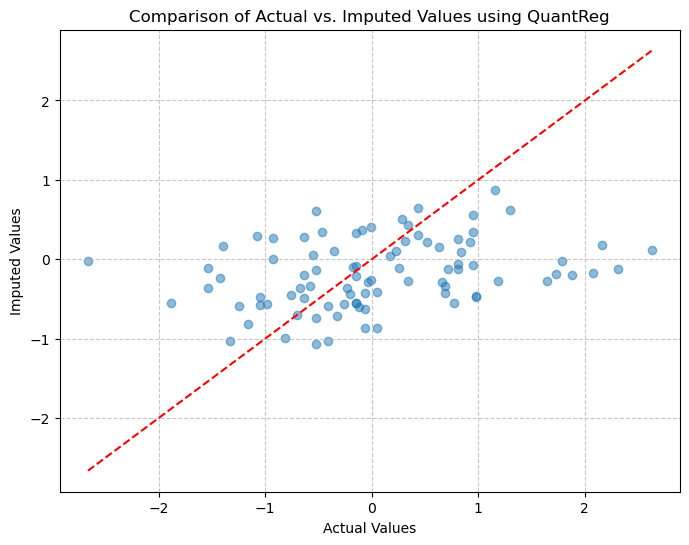

In [14]:
# Extract median predictions for evaluation
median_predictions = imputed_values[0.5]

# Create a scatter plot comparing actual vs. imputed values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, median_predictions, alpha=0.5)
plt.plot([actual_values.min().min(), actual_values.max().max()], 
         [actual_values.min().min(), actual_values.max().max()], 
         'r--')
plt.xlabel('Actual Values')
plt.ylabel('Imputed Values')
plt.title('Comparison of Actual vs. Imputed Values using QuantReg')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Examining Quantile Predictions

Quantile regression provides predictions at different quantiles, which helps us understand the entire conditional distribution of the missing values.

In [18]:
# Compare predictions at different quantiles for the first 5 records
quantiles_to_show = QUANTILES
comparison_df = pd.DataFrame(index=range(5))

# Add actual values
comparison_df['Actual'] = actual_values.iloc[:5, 0].values

# Add quantile predictions
for q in quantiles_to_show:
    comparison_df[f'Q{int(q*100)}'] = imputed_values[q].iloc[:5, 0].values

comparison_df

,Actual,Q5,Q10,Q30,Q50,Q70,Q90,Q95
0,2.625393,-1.152139,-0.948903,-0.344479,0.114081,0.567533,1.467549,1.682980
1,-0.524163,-0.760426,-0.546681,0.124764,0.611501,1.084328,2.199062,2.565419
2,2.163073,-1.361470,-1.177171,-0.331706,0.173160,0.590333,1.593308,1.911314
3,1.151747,-0.524383,-0.291581,0.362828,0.873379,1.291925,2.384667,2.942231
4,0.805007,-1.512259,-1.351796,-0.586963,-0.118618,0.292050,1.095727,1.497126


## Visualizing Prediction Intervals

One of the key advantages of quantile regression is its ability to provide prediction intervals that can adapt to different parts of the distribution.

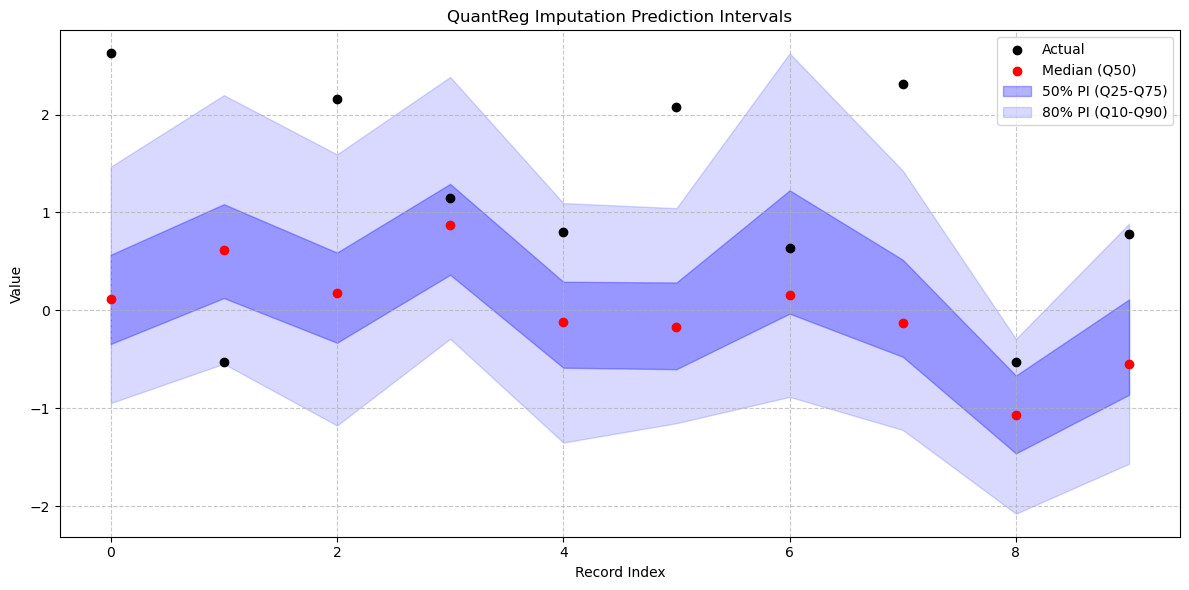

In [20]:
# Create a prediction interval plot for the first 10 records
plt.figure(figsize=(12, 6))

# Number of records to plot
n_records = 10

# X-axis positions
x = np.arange(n_records)

# Plot actual values
plt.scatter(x, actual_values.iloc[:n_records, 0], color='black', label='Actual', zorder=3)

# Plot median predictions
plt.scatter(x, imputed_values[0.5].iloc[:n_records, 0], color='red', label='Median (Q50)', zorder=3)

# Plot 50% prediction interval (Q25 to Q75)
plt.fill_between(x, 
                 imputed_values[0.3].iloc[:n_records, 0],
                 imputed_values[0.7].iloc[:n_records, 0],
                 alpha=0.3, color='blue', label='50% PI (Q25-Q75)')

# Plot 80% prediction interval (Q10 to Q90)
plt.fill_between(x, 
                 imputed_values[0.1].iloc[:n_records, 0],
                 imputed_values[0.9].iloc[:n_records, 0],
                 alpha=0.15, color='blue', label='80% PI (Q10-Q90)')

plt.xlabel('Record Index')
plt.ylabel('Value')
plt.title('QuantReg Imputation Prediction Intervals')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Assesing the Method's Performance

To check whether our model is overfitting and ensure robust results we can perform cross-validation and visualize the results.

In [23]:
# Run cross-validation on the same data set 
quantreg_results = cross_validate_model(
        QuantReg, diabetes_df, predictors, imputed_variables)

quantreg_results

,0.05,0.10,0.30,0.50,0.70,0.90,0.95
train,0.004002,0.006926,0.014599,0.017156,0.015698,0.008563,0.005143
test,0.004121,0.007078,0.015050,0.017573,0.015992,0.008787,0.005401


In [24]:
# Plot the results
plot_train_test_performance(quantreg_results)